Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [103]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [123]:
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import pandas as pd
import plotly_express as px
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [105]:
df=pd.read_csv('https://raw.githubusercontent.com/VeraMendes/Project---Train-a-predictive-model/master/led.csv')
print(df.shape)

(2938, 22)


In [35]:
# looking into nan's
df.isnull().sum()

Country                           0
Year                              0
Status                            0
Lifeexpectancy                   10
AdultMortality                   10
infantdeaths                      0
Alcohol                         194
percentageexpenditure             0
HepatitisB                      553
Measles                           0
BMI                              34
under-fivedeaths                  0
Polio                            19
Totalexpenditure                226
Diphtheria                       19
HIV/AIDS                          0
GDP                             448
Population                      652
thinness1-19years                34
thinness5-9years                 34
Incomecompositionofresources    167
Schooling                       163
dtype: int64

In [36]:
# finding the nan's for lifeexpectancy
df[pd.isnull(df['Lifeexpectancy'])]

,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
624,CookIslands,2013,Developing,NaN,NaN,0,0.01,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,11.419555,96.0,0,...,96.0,5.58,96.0,0.1,722.756650,NaN,2.7,2.6,0.721,12.7
1650,MarshallIslands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1715,Monaco,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,4.30,99.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1812,Nauru,2013,Developing,NaN,NaN,0,0.01,15.606596,87.0,0,...,87.0,4.65,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6
1909,Niue,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,7.20,99.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
1958,Palau,2013,Developing,NaN,NaN,0,NaN,344.690631,99.0,0,...,99.0,9.27,99.0,0.1,1932.122370,292.0,0.1,0.1,0.779,14.2
2167,SaintKittsandNevis,2013,Developing,NaN,NaN,0,8.54,0.000000,97.0,0,...,96.0,6.14,96.0,0.1,NaN,NaN,3.7,3.6,0.749,13.4
2216,SanMarino,2013,Developing,NaN,NaN,0,0.01,0.000000,69.0,0,...,69.0,6.50,69.0,0.1,NaN,NaN,NaN,NaN,NaN,15.1
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


In [37]:
# checkig all my column names
df.columns

Index(['Country', 'Year', 'Status', 'Lifeexpectancy', 'AdultMortality',
       'infantdeaths', 'Alcohol', 'percentageexpenditure', 'HepatitisB',
       'Measles', 'BMI', 'under-fivedeaths', 'Polio', 'Totalexpenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness1-19years',
       'thinness5-9years', 'Incomecompositionofresources', 'Schooling'],
      dtype='object')

In [106]:
# changing my column names
df = df.rename(columns = {
    'Country':'country','Year':'year', 'Status':'development','Lifeexpectancy':'lifespan',
    'AdultMortality':'adult_mortality', 'infantdeaths':'infant_deaths',
    'Alcohol':'alcohol_consumption', 'percentageexpenditure':'percentage_expenditure',
    'HepatitisB':'hepatitisb','Measles':'measles','BMI':'BMI','under-fivedeaths':'baby_deaths',
    'Polio':'polio', 'Totalexpenditure':'total_expenditure','Diphtheria':'diphtheria','HIV/AIDS':'HIV/AIDS',
    'GDP':'GDP','Population':'population','thinness1-19years':'thinness_teenager',
    'thinness5-9years':'thinness_children','Incomecompositionofresources':'ICR','Schooling':'education'
})

df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_consumption,percentage_expenditure,hepatitisb,measles,...,polio,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [107]:
# dropping nan's for lifespan
df = df.dropna(axis=0, subset=['lifespan'])
# checking dimnesions of my df
df.shape
# due to leakage problems, I am creating a new column which is going to be my y_target: next_year_lifespan
df['next_year_lifespan']= df['lifespan'].shift(1)
# 2015 does not have data on y_target for any country
# With pd.shift, I have moved into 2015 wrong values for the countries considered.
year_2015 = df[df.year == 2015]
# For my analysis I am dropping 2015 rows to avoid errors and leakage.
df = df[df.year != 2015]
df.head()

,country,year,development,lifespan,adult_mortality,infant_deaths,alcohol_consumption,percentage_expenditure,hepatitisb,measles,...,total_expenditure,diphtheria,HIV/AIDS,GDP,population,thinness_teenager,thinness_children,ICR,education,next_year_lifespan
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,65.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.9
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,59.2


### Looking into Time Series I am:
### using 2013 & 2014 as test
### using 2011 & 2012 as val
### I cannot use 2015 values as I don't have values for the next year lifespan (2016)

In [108]:
# splitting my data into a time series manner
train = df[df['year']<2011]
val = df[(df.year == 2011) | (df.year == 2012)]
test = df[(df.year == 2013) | (df.year == 2014)]
train.shape, val.shape, test.shape

((2013, 23), (366, 23), (366, 23))

In [41]:
# looking into nan's
df.isnull().sum()

country                     0
year                        0
development                 0
lifespan                    0
adult_mortality             0
infant_deaths               0
alcohol_conpsumption       16
percentage_expenditure      0
hepatitisb                544
measles                     0
BMI                        30
baby_deaths                 0
polio                      19
total_expenditure          45
diphtheria                 19
HIV/AIDS                    0
GDP                       414
population                603
thinness_teenager          30
thinness_children          30
ICR                       150
education                 150
next_year_lifespan          0
dtype: int64

In [92]:
# Arrange data into X features matrix and y target vector
# removing previous year lifespan from all my data
target = 'next_year_lifespan'
baseline_values = 'lifespan'
cols_to_drop = ['next_year_lifespan', 'lifespan']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [48]:
# using previous year lifespan, as y_pred = y_baseline
y_baseline = pd.Series(train['lifespan'], index=train.index)
# using previous year lifespan, as y_pred = y_baseline to try to find a better model fit
mean_baseline = train['next_year_lifespan'].mean()
y_pred = val['lifespan']
baseline_mae = mean_absolute_error(y_val, y_pred)
print('mean baseline:', train['next_year_lifespan'].mean())
print(f'Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): {baseline_mae:.4f}')

mean baseline: 68.68564331843021
Mean Absolut Error of the baseline prediction (predict lifespan for years 2011 & 2012): 0.8281


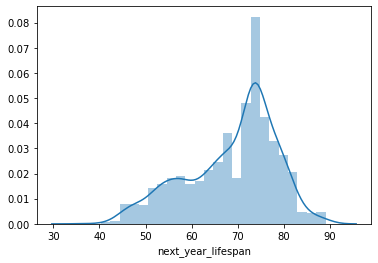

In [49]:
sns.distplot(y_train);

In [54]:
pipeline = make_pipeline(
ce.OrdinalEncoder(),
XGBRegressor(learning_rate=0.1,
             max_depth=7, n_estimators=2000,
             n_jobs=-1, objective='reg:linear')
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

[16:12:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolut error: 1.2408877409221042


In [56]:
pipeline = make_pipeline(
ce.OrdinalEncoder(),
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

[16:14:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolut error: 1.2408877409221042


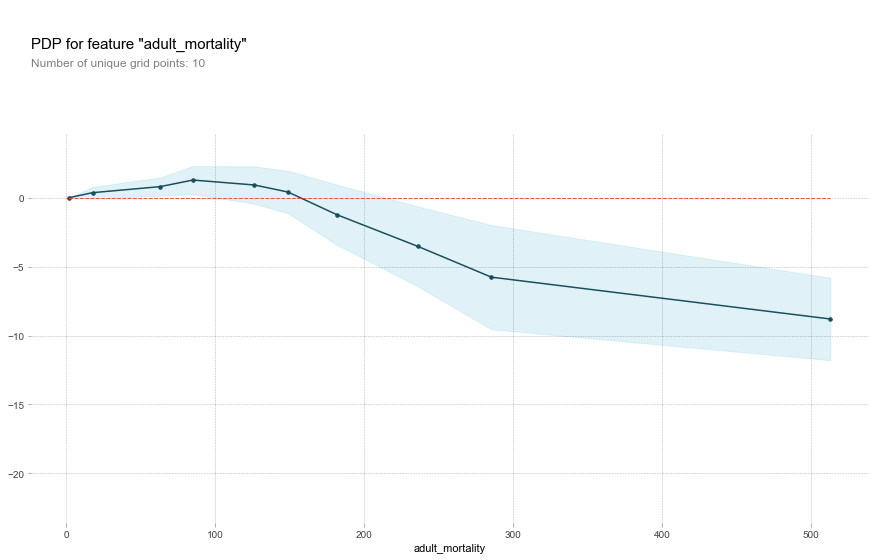

In [72]:
feature = 'adult_mortality'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

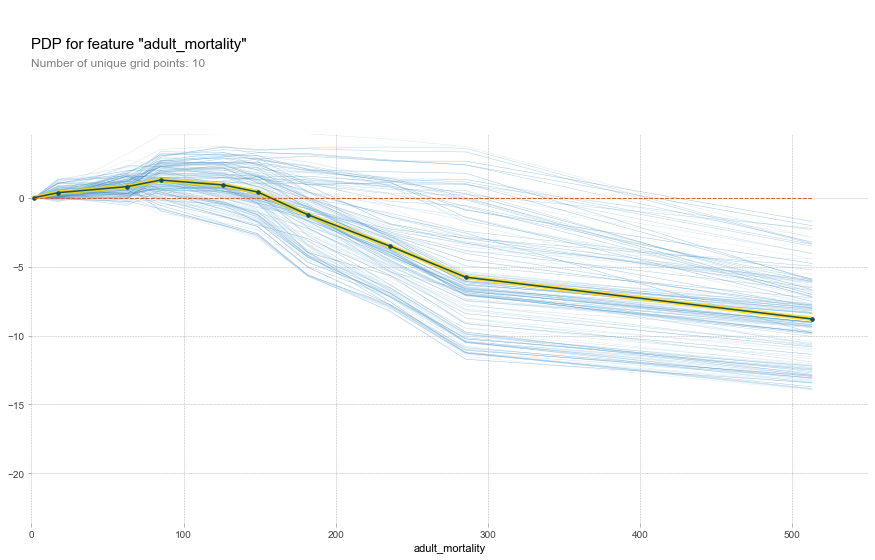

In [73]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=150)
plt.xlim(0,550);

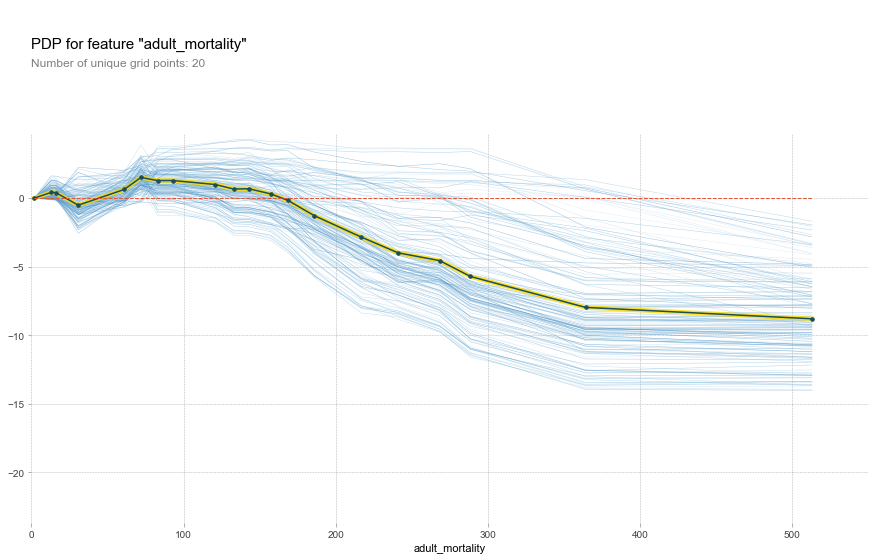

In [77]:
isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns,
    feature=feature, 
    num_grid_points=20
)
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=150) # Confusing parameter name
plt.xlim(0,550);

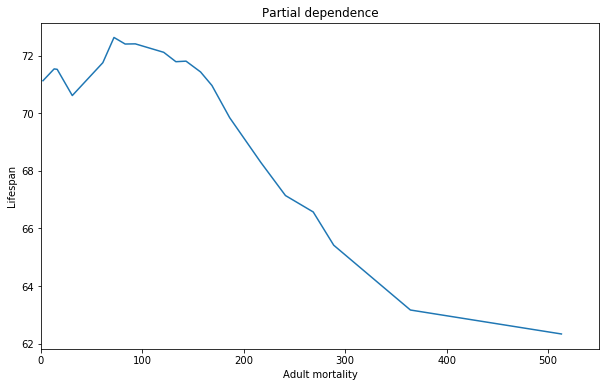

In [76]:
grid = isolated.feature_grids
pdp = isolated.pdp

plt.figure(figsize=(10,6))
plt.plot(grid, pdp)
plt.xlim(0,550)
plt.xlabel('Adult mortality')
plt.ylabel('Lifespan')
plt.title('Partial dependence');

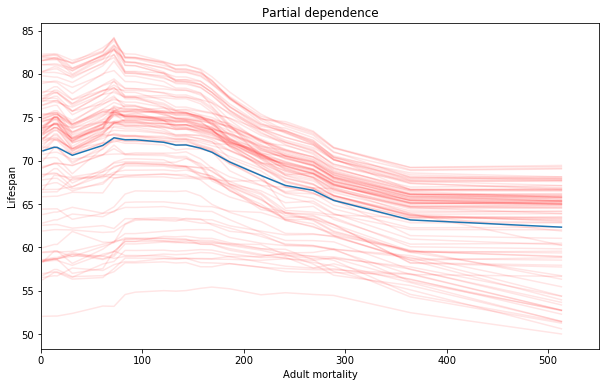

In [79]:
ice = isolated.ice_lines.sample(n=100).T

ice.plot(color='red', alpha=0.1, legend=False, figsize=(10,6))
plt.plot(grid, pdp)
plt.xlim(0,550)
plt.xlabel('Adult mortality')
plt.ylabel('Lifespan')
plt.title('Partial dependence');

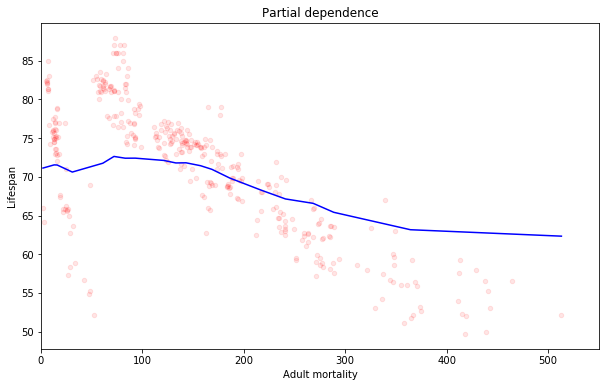

In [84]:
val.plot.scatter(x='adult_mortality', y='next_year_lifespan', 
                 color='red', alpha=0.1, figsize=(10,6))

plt.plot(grid, pdp, color='b')
plt.xlim(0,550)
plt.xlabel('Adult mortality')
plt.ylabel('Lifespan')
plt.title('Partial dependence');

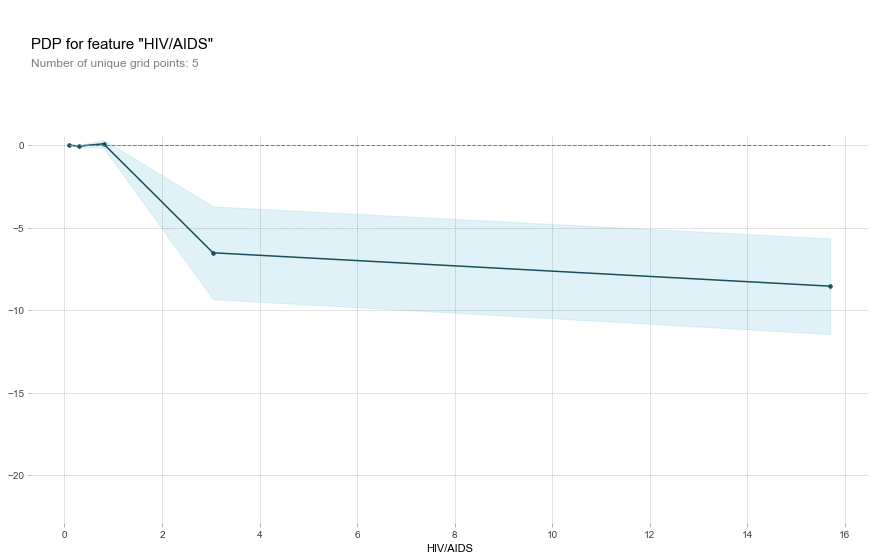

In [59]:
feature = 'HIV/AIDS'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

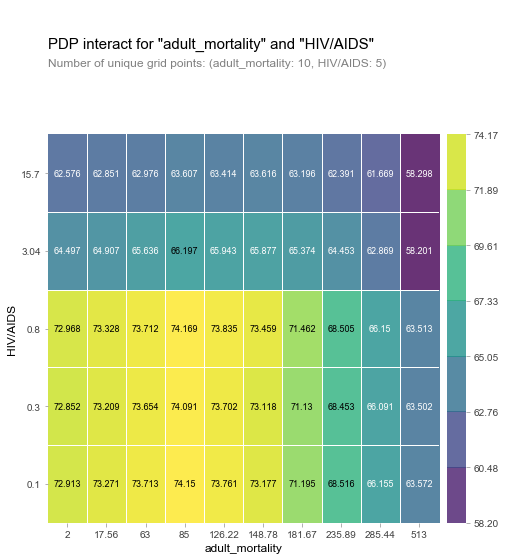

In [87]:
features = ['adult_mortality', 'HIV/AIDS']

interactive = pdp_interact(
model=pipeline,
dataset=X_val,
model_features = X_val.columns,
features = features
)

pdp_interact_plot(interactive, plot_type='grid', feature_names=features);

In [112]:
# choosing different X features matrix & y target vector
target = 'next_year_lifespan'
cols_to_drop = ['next_year_lifespan', 'lifespan', 'year', 'thinness_teenager', 'diphtheria', 'GDP', 'infant_deaths']
X_train = train[train.columns.drop(cols_to_drop)]
y_train = train['next_year_lifespan']
X_val = val[val.columns.drop(cols_to_drop)]
y_val = val['next_year_lifespan']
X_test = test[test.columns.drop(cols_to_drop)]
y_test = test['next_year_lifespan']

In [128]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    DecisionTreeRegressor()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 2.181147540983607


In [132]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

model = Ridge()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 2.8897216261877197


In [135]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

model = LinearRegression()
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_val_transformed)
print('Mean Absolut error:', mean_absolute_error(y_val, y_pred))

Mean Absolut error: 2.8878120612494467


### As none of these models are working any better than the baseline model, my next idea is to pick up the best features from feature permutation and create some more random data based on these features.